In [1]:
!pip install optuna
!pip install datasets

In [2]:
pip install --upgrade datasets fsspec


In [3]:
#!pip install datasets
from datasets import load_dataset

#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")
from sklearn.metrics import auc, roc_curve, precision_score, recall_score, precision_recall_curve

import optuna
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from xgboost import XGBClassifier


import numpy as np

Setup Complete


In [4]:
dataset = load_dataset("criteo/FairJob")

# Accéder à l'ensemble d'entraînement
df = dataset['train'].to_pandas()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.14k [00:00<?, ?B/s]

fairjob.csv.gz:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1072226 [00:00<?, ? examples/s]

In [11]:
ds = load_dataset("criteo/FairJob")
df = ds['train'].to_pandas()

ValueError: Invalid pattern: '**' can only be an entire path component

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Metrics

def click_rank_utility(df, y_pred):
    """
    Implémente la fonction Click-Rank Utility U(f).
    """
    df_test = df.loc[y_pred.index].copy()
    df_test = df_test.assign(pred=y_pred)

    # Evite le biais de position
    df_test = df_test[df_test['displayrandom'] == 1].copy()

    # Trier les produits affichés dans chaque impression par score de prédiction croissant
    df_test = df_test.sort_values(by=['impression_id', 'pred'], ascending=[True, True])

    # Calcul du rank
    df_test['rank_order'] = df_test.groupby('impression_id')['pred'].rank(method='min', ascending=True)

    # I(Y_D = 1) * rank_J f(X_J, D)
    df_test['utility'] = df_test['click'] * df_test['rank_order']

    # Moyenne de U(f) sur chaque impression’
    click_rank_per_impression = df_test.groupby('impression_id')['utility'].mean()

    # Moyenne finale sur toutes les bannières
    return click_rank_per_impression.mean()

def nllh(y_true, y_pred):
    y_pred_np = np.array(y_pred) + 1e-15
    y_true_np = np.array(y_true)

    epsilon = 1e-15

    y_pred_clip = np.clip(y_pred_np, epsilon, 1 - epsilon)

    log_loss_np = y_true_np * np.log(y_pred_clip) + (1 - y_true_np) * np.log(1 - y_pred_clip)
    return -np.mean(log_loss_np)

def DP(predictions, protected_attribute, scope):
     """
    Function to compute demographic parity with respect to scope.

    Args:
        predictions: model predictions (numpy array or pandas Series) for class 1 (probability of click)
        protected_attribute: protected attribute values (numpy array or pandas Series)
        scope: indicator for scope (numpy array or pandas Series)

    Returns:
       Demographic parity
    """

     predictions = np.array(predictions)  # Assurer que predictions est un tableau numpy
     res = 0.0  # Initialiser le résultat

    # Filtrer les prédictions où scope > 0 (par exemple, impressions valides)
     pred_group_1 = predictions[(protected_attribute > 0) & (scope > 0)]  # Groupe 1 (par exemple, groupe protégé)
     pred_group_2 = predictions[(protected_attribute <= 0) & (scope > 0)]  # Groupe 2 (par exemple, groupe non protégé)

    # Calculer la moyenne des prédictions pour chaque groupe
     mean_group_1 = np.mean(pred_group_1)
     mean_group_2 = np.mean(pred_group_2)

    # Ajouter la différence absolue au résultat
     res += np.abs(mean_group_1 - mean_group_2)

     return res


def AUC(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    return auc(fpr, tpr)

def report_results(df, y_pred_prob, y_pred):

    if not isinstance(y_pred, pd.Series):
        raise ValueError("y_pred must be a pandas Series")

    df_test = df.loc[y_pred.index].copy()
    y_true = df_test['click']
    scope = df_test['displayrandom'] == 1

    click_rank_value = click_rank_utility(df, y_pred)
    nllh_value = nllh(y_true, y_pred_prob)
    auc_value = AUC(y_true, y_pred_prob)
    dp_value = DP(y_pred_prob, df_test['protected_attribute'], scope)

    return {
    'Click Rank Utility': round(click_rank_value, 5),
    'Negative Log-Likelihood': round(nllh_value, 5),
    'AUC': round(auc_value, 5),
    'Demographic Parity': round(dp_value, 5)
}

In [5]:
from sklearn.metrics import log_loss

def print_results(X_test, y_test, model):
    # Calcul des probabilités des prédictions
    y_scores = model.predict_proba(X_test)[:, 1]  # Probabilité d'être classe 1

    # Calcul des courbes précision-rappel
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Calcul du F1-score pour chaque seuil
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Évite division par zéro

    # Trouver l'index du meilleur F1-score
    best_threshold_index = np.argmax(f1_scores)

    # Le tableau "thresholds" est plus court d'un élément → il faut ajuster l'indexation
    if best_threshold_index == 0:  # Si le max est au début, on prend le premier seuil
        best_threshold = thresholds[0]
    else:
        best_threshold = thresholds[best_threshold_index - 1]

    # Précision et rappel au meilleur seuil
    precision_optimal = precisions[best_threshold_index]
    recall_optimal = recalls[best_threshold_index]
    f1_score_optimal = f1_scores[best_threshold_index]

    # Calcul du log loss
    log_loss_value = log_loss(y_test, y_scores)

    print(f'Best Threshold: {best_threshold}')
    print(f'\nPrecision at Best Threshold: {precision_optimal}')
    print(f'Recall at Best Threshold: {recall_optimal}')
    print(f'F1 Score at Best Threshold: {f1_score_optimal}')
    print(f'Log Loss: {log_loss_value}')

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[1:], label='Précision', color='blue')
    plt.plot(thresholds, recalls[1:], label='Recall', color='red')
    plt.axvline(x=best_threshold, color='green', linestyle='--', label="Seuil Optimal")
    plt.xlabel("Seuil de classification")
    plt.ylabel("Score")
    plt.title("Courbe Précision-Recall en fonction du seuil")
    plt.legend()
    plt.grid()
    plt.show()


In [6]:
from sklearn.metrics import log_loss
import numpy as np

def evaluate_log_loss_by_class(y_true, y_proba):
    """
    Calcule la log loss globale, la log loss par classe, et la confiance moyenne sur les vrais positifs.

    Parameters
    ----------
    y_true : array-like
        Vecteur des vraies étiquettes (0 ou 1)
    y_proba : array-like, shape (n_samples, 2)
        Probabilités prédites (sorties de predict_proba)

    Returns
    -------
    dict with:
        - 'log_loss_global'
        - 'log_loss_y0'
        - 'log_loss_y1'
        - 'mean_proba_y1' (moyenne des p(y=1) quand y=1)
    """
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    return {
        "log_loss_global": round(log_loss(y_true, y_proba), 5),
        "log_loss_y0": round(log_loss(y_true[y_true == 0], y_proba[y_true == 0], labels=[0, 1]), 5),
        "log_loss_y1": round(log_loss(y_true[y_true == 1], y_proba[y_true == 1], labels=[0, 1]), 5),
        "mean_proba_y1": round(float(y_proba[y_true == 1, 1].mean()), 5)
        }



In [23]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['click','user_id','impression_id','product_id'])
y = df['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from xgboost import XGBClassifier


xgb_tree_method = "hist"

cat_cols_bin = list(X_train.columns[0:3])
rank_col = ['rank']
cat_cols = list(X_train.columns[4:17])

data_preproc = ColumnTransformer([('multicat_encoding', TargetEncoder(target_type='binary'), cat_cols)],
                              remainder='passthrough', force_int_remainder_cols=False)

xgb_pipe = Pipeline([('preprocessing', data_preproc),
                     ('xgb',XGBClassifier())])

In [ ]:
scale_pos_weight = (
        (np.sum(y_train < 1) / np.sum(y_train > 0))
    )

def objective(trial):
    X_train_train, X_val, y_train_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train
    )

    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_float("min_child_weight", 0.0001, 100, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0.1, 10, log=True)
    gamma = trial.suggest_float("gamma", 0.001, 100, log=True)
    base_score = trial.suggest_float("base_score", 1e-4, 1 - 1e-4)


    xgb_params = {
        'xgb__max_depth': max_depth,
        'xgb__min_child_weight': min_child_weight,
        'xgb__subsample': subsample,
        'xgb__learning_rate': learning_rate,
        'xgb__colsample_bytree': colsample_bytree,
        'xgb__reg_lambda': reg_lambda,
        'xgb__gamma': gamma,
        'xgb__base_score': base_score,
        'xgb__scale_pos_weight': scale_pos_weight,
    }

    xgb_pipe.set_params(**xgb_params)
    xgb_pipe.fit(X_train_train, y_train_train)

    prob_val = xgb_pipe.predict_proba(X_val)

    return log_loss(y_val, prob_val)

n_trials = 100 # Increase to ~100

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_trials)
optimal_no_scale = study.best_trial

print("\nOptimization done")

xgb_tuned_params = {
    'xgb__max_depth': optimal_no_scale.params["max_depth"],
    'xgb__min_child_weight': optimal_no_scale.params["min_child_weight"],
    'xgb__gamma': optimal_no_scale.params["gamma"],
    'xgb__subsample': optimal_no_scale.params["subsample"],
    'xgb__learning_rate': optimal_no_scale.params["learning_rate"],
    'xgb__colsample_bytree': optimal_no_scale.params["colsample_bytree"],
    'xgb__reg_lambda': optimal_no_scale.params["reg_lambda"],
    'xgb__base_score': optimal_no_scale.params["base_score"],
    'xgb__scale_pos_weight': scale_pos_weight,
}

xgb_pipe.set_params(**xgb_tuned_params)
xgb_pipe.fit(X_train, y_train)

print("\nEntrainement terminé")

xgb_adapted_scale_tuned = evaluate_log_loss_by_class(y_test, xgb_pipe.predict_proba(X_test))

[I 2025-05-11 21:49:40,107] A new study created in memory with name: no-name-d5df99b8-2d17-4449-9d25-b9cbc575305c
[I 2025-05-11 21:50:00,589] Trial 0 finished with value: 1.2630263058938274 and parameters: {'max_depth': 5, 'min_child_weight': 0.023145449412042034, 'subsample': 0.5337577993503071, 'learning_rate': 0.0028956622984516664, 'colsample_bytree': 0.5973955087203415, 'reg_lambda': 2.6457085283639015, 'gamma': 0.060707933536859576, 'base_score': 0.8381494870019436}. Best is trial 0 with value: 1.2630263058938274.
[I 2025-05-11 21:50:28,789] Trial 1 finished with value: 0.07557839682767459 and parameters: {'max_depth': 8, 'min_child_weight': 0.009329021065069248, 'subsample': 0.6270882918686398, 'learning_rate': 0.0018139831227137323, 'colsample_bytree': 0.8030280113837792, 'reg_lambda': 4.6381567252751115, 'gamma': 47.76501283746983, 'base_score': 0.013724004726761484}. Best is trial 1 with value: 0.07557839682767459.
[I 2025-05-11 21:51:00,943] Trial 2 finished with value: 0.63


Optimization done

Entrainement terminé



# Regularization

In [11]:
from sklearn.model_selection import train_test_split

X1 = df.drop(columns=['click','user_id','impression_id','product_id','protected_attribute'])
y1 = df['click']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

In [13]:
# Define preprocess + pipeline

cat_cols_bin1 = list(X_train1.columns[0:3])
rank_col1 = ['rank']
cat_cols1 = list(X_train1.columns[4:17])

data_preproc1 = ColumnTransformer([('multicat_encoding', TargetEncoder(target_type='binary'), cat_cols1)],
                              remainder='passthrough', force_int_remainder_cols=False)

xgb_pipe = Pipeline([('preprocessing', data_preproc1),
                     ('xgb',XGBClassifier())])

# Set params

scale_pos_weight1 = (
        (np.sum(y_train1 < 1) / np.sum(y_train1 > 0))
    )

params = {
  "xgb__max_depth": 10,
  "xgb__min_child_weight": 0.06439182463367363,
  "xgb__gamma": 0.0013821775931869263,
  "xgb__subsample": 0.9635299142536724,
  "xgb__learning_rate": 0.42805261439009434,
  "xgb__colsample_bytree": 0.7544548929145419,
  "xgb__reg_lambda": 0.583011401512898,
  "xgb__base_score": 0.4543459538572563,
  "xgb__scale_pos_weight": scale_pos_weight1
}

xgb_pipe.set_params(**params)
xgb_pipe.fit(X_train1, y_train1)
prob1 = xgb_pipe.predict_proba(X_test1)

Best Threshold: 0.36410632729530334

Precision at Best Threshold: 0.06436233611442194
Recall at Best Threshold: 0.14419225634178906
F1 Score at Best Threshold: 0.08899876347931601
Log Loss: 0.06219166902468224


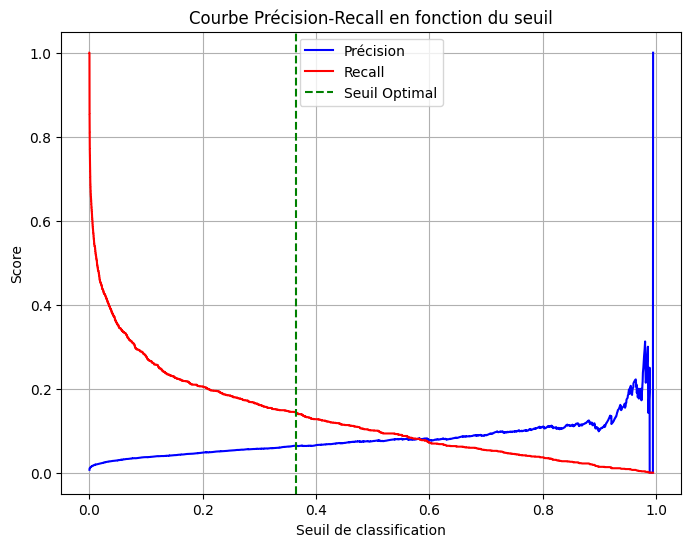

In [14]:
model1 = xgb_pipe.named_steps['xgb']
print_results(X_test1, y_test1, xgb_pipe)

In [15]:

best_threshold =  0.460674911737442

y_pred_proba = pd.Series(prob1[:, 1], index=X_test1.index)
y_pred = (y_pred_proba > best_threshold).astype(int)

In [22]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import equalized_odds_difference

positive_rate_0= np.mean(y_pred[X_test['protected_attribute'] == 0])
positive_rate_1= np.mean(y_pred[X_test['protected_attribute'] == 1])


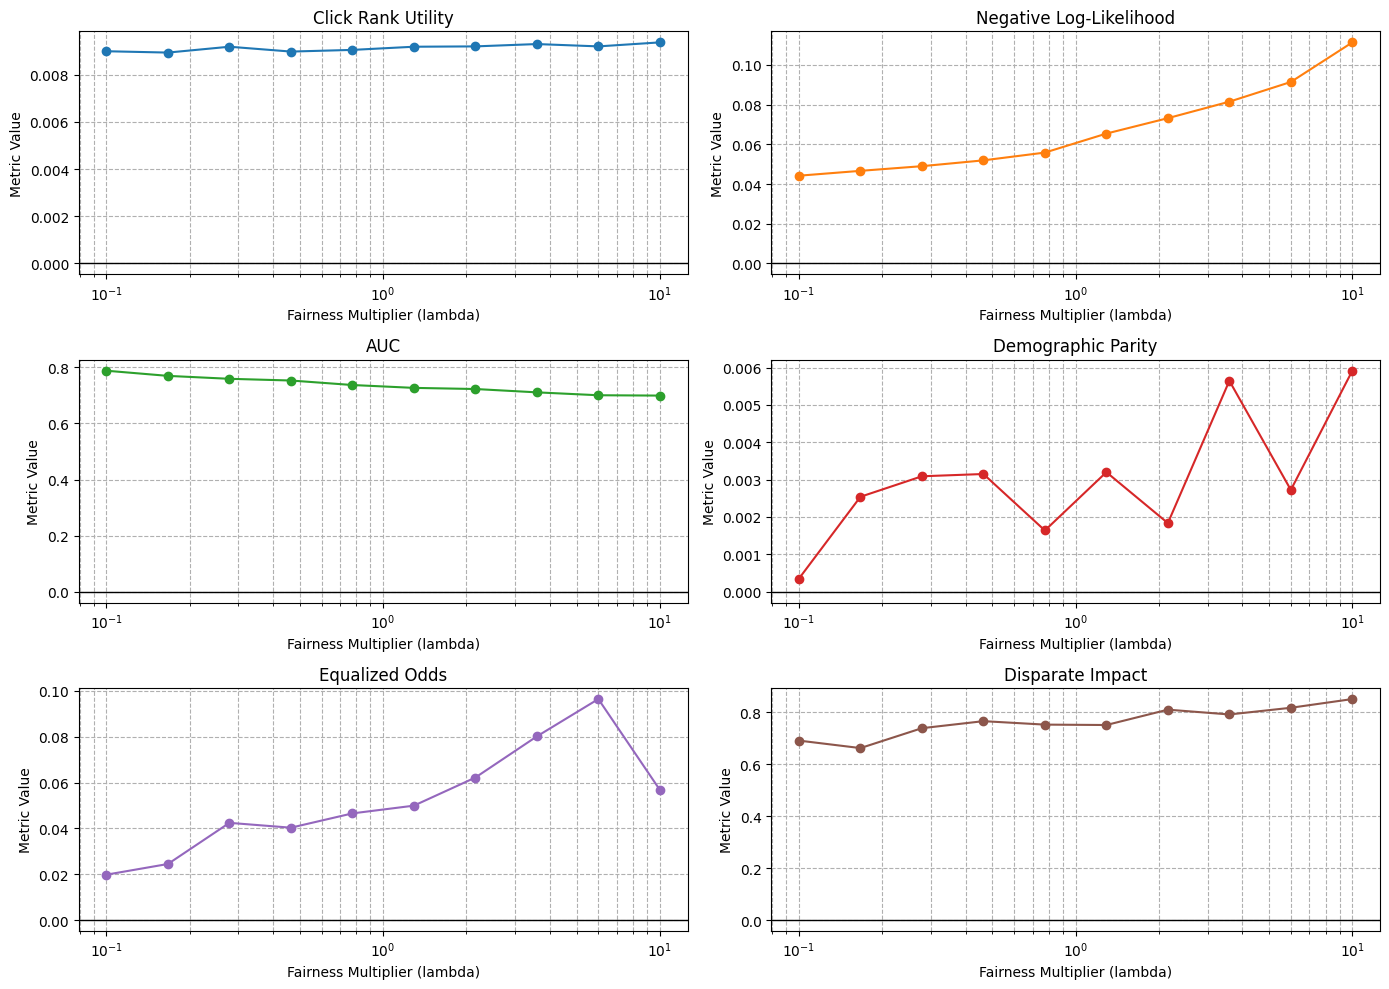

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import equalized_odds_difference
# Liste des multiplicateurs de lambda à tester
lambda_values = np.logspace(-1, 1, 10)  # Valeurs de lambda entre 0.1 et 10, sur une échelle logarithmique

# Initialisation des listes pour stocker les résultats
metrics_over_lambda = {
    'Click Rank Utility': [],
    'Negative Log-Likelihood': [],
    'AUC': [],
    'Demographic Parity': [],
    'Equalized Odds': [],
    'Disparate Impact': []
}

# Boucle sur les valeurs de lambda
for lambda_ in lambda_values:
    # Mettre à jour le paramètre de régularisation dans le modèle
    xgb_pipe.set_params(xgb__scale_pos_weight=scale_pos_weight1 * lambda_)

    # Réentraîner le modèle avec cette valeur de lambda
    xgb_pipe.fit(X_train1, y_train1)
    prob = xgb_pipe.predict_proba(X_test)
    y_pred_proba = pd.Series(prob[:, 1], index=X_test.index)
    y_pred = (y_pred_proba > best_threshold).astype(int)

    # Calcul des métriques de performance
    click_rank_value = click_rank_utility(df, y_pred)
    nllh_value = nllh(y_test, y_pred_proba)
    auc_value = AUC(y_test, y_pred_proba)

    # Calcul des métriques d’équité
    dp_value = DP(y_pred_proba, X_test['protected_attribute'], X_test['displayrandom'])
    equalized_odds_value = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test['protected_attribute'])
    positive_rate_0 = np.mean(y_pred[X_test['protected_attribute'] == 0])
    positive_rate_1 = np.mean(y_pred[X_test['protected_attribute'] == 1])
    disparate_impact_value = positive_rate_1 / positive_rate_0

    # Stocker les résultats
    metrics_over_lambda['Click Rank Utility'].append(click_rank_value)
    metrics_over_lambda['Negative Log-Likelihood'].append(nllh_value)
    metrics_over_lambda['AUC'].append(auc_value)
    metrics_over_lambda['Demographic Parity'].append(dp_value)
    metrics_over_lambda['Equalized Odds'].append(equalized_odds_value)
    metrics_over_lambda['Disparate Impact'].append(disparate_impact_value)

# Tracer les résultats
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (metric, values) in enumerate(metrics_over_lambda.items()):
    axes[idx].plot(lambda_values, values, marker='o', label=metric, linestyle='-', color=sns.color_palette("tab10")[idx])
    axes[idx].set_xscale('log')  # Log scale pour lambda
    axes[idx].set_title(metric)
    axes[idx].set_xlabel('Fairness Multiplier (lambda)')
    axes[idx].set_ylabel('Metric Value')
    axes[idx].grid(True, which="both", ls="--")
    axes[idx].axhline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()


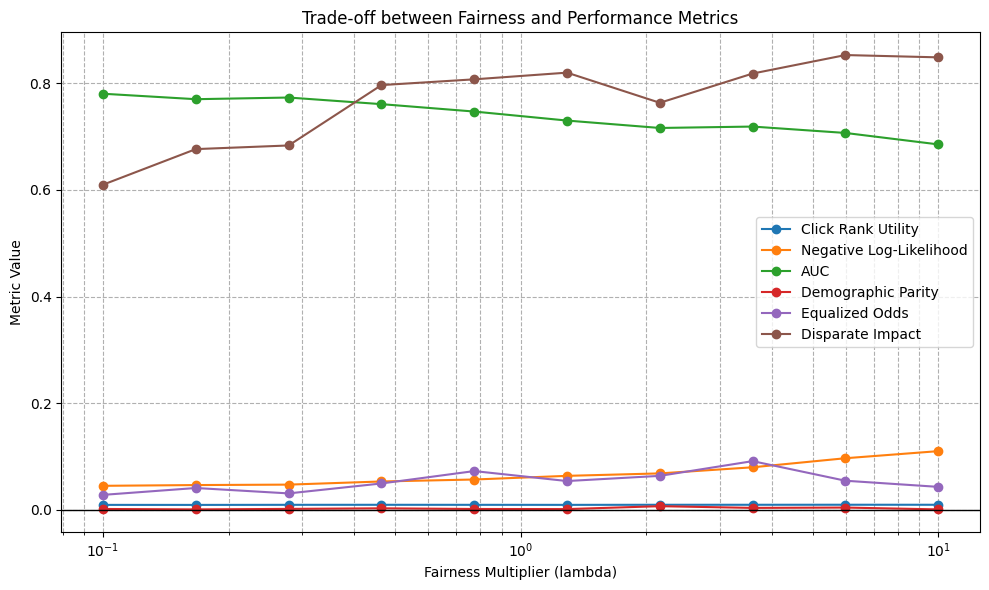

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Liste des multiplicateurs de lambda à tester
lambda_values = np.logspace(-1, 1, 10)  # Valeurs de lambda entre 0.1 et 10, sur une échelle logarithmique

# Initialisation des listes pour stocker les résultats
metrics_over_lambda = {
    'Click Rank Utility': [],
    'Negative Log-Likelihood': [],
    'AUC': [],
    'Demographic Parity': [],
    'Equalized Odds': [],
    'Disparate Impact': []
}

# Boucle sur les valeurs de lambda
for lambda_ in lambda_values:
    # Ajuster le paramètre de régularisation pour équité
    xgb_pipe.set_params(xgb__scale_pos_weight=scale_pos_weight1 * lambda_)

    # Réentraîner le modèle avec cette valeur de lambda
    xgb_pipe.fit(X_train1, y_train1)
    prob = xgb_pipe.predict_proba(X_test1)
    y_pred_proba = pd.Series(prob[:, 1], index=X_test1.index)
    y_pred = (y_pred_proba > best_threshold).astype(int)

    # Calcul des métriques de performance
    click_rank_value = click_rank_utility(df, y_pred)
    nllh_value = nllh(y_test1, y_pred_proba)
    auc_value = AUC(y_test1, y_pred_proba)

    # Calcul des métriques d’équité
    dp_value = DP(y_pred_proba, X_test['protected_attribute'], X_test['displayrandom'])
    equalized_odds_value = equalized_odds_difference(y_true=y_test1, y_pred=y_pred, sensitive_features=X_test['protected_attribute'])
    positive_rate_0 = np.mean(y_pred[X_test['protected_attribute'] == 0])
    positive_rate_1 = np.mean(y_pred[X_test['protected_attribute'] == 1])
    disparate_impact_value = positive_rate_1 / positive_rate_0

    # Stocker les résultats pour chaque lambda
    metrics_over_lambda['Click Rank Utility'].append(click_rank_value)
    metrics_over_lambda['Negative Log-Likelihood'].append(nllh_value)
    metrics_over_lambda['AUC'].append(auc_value)
    metrics_over_lambda['Demographic Parity'].append(dp_value)
    metrics_over_lambda['Equalized Odds'].append(equalized_odds_value)
    metrics_over_lambda['Disparate Impact'].append(disparate_impact_value)

# Superposer les graphiques dans un seul plot
plt.figure(figsize=(10, 6))

for idx, (metric, values) in enumerate(metrics_over_lambda.items()):
    plt.plot(lambda_values, values, marker='o', label=metric, linestyle='-', color=sns.color_palette("tab10")[idx])

# Configuration du graphique
plt.xscale('log')  # Log scale pour lambda
plt.title('Trade-off between Fairness and Performance Metrics')
plt.xlabel('Fairness Multiplier (lambda)')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.axhline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Liste des multiplicateurs de lambda à tester
lambda_values = np.logspace(-1, 1, 10)  # Valeurs de lambda entre 0.1 et 10, sur une échelle logarithmique

# Initialisation des listes pour stocker les résultats
metrics_over_lambda = {
    'Click Rank Utility': [],
    'Negative Log-Likelihood': [],
    'AUC': [],
    'Demographic Parity': [],
    'Equalized Odds': [],
    'Disparate Impact': []
}

# Boucle sur les valeurs de lambda
for lambda_ in lambda_values:
    # Ajuster le paramètre de régularisation pour équité
    xgb_pipe.set_params(xgb__scale_pos_weight=scale_pos_weight1 * lambda_)

    # Réentraîner le modèle avec cette valeur de lambda
    xgb_pipe.fit(X_train1, y_train1)
    prob = xgb_pipe.predict_proba(X_test1)
    y_pred_proba = pd.Series(prob[:, 1], index=X_test1.index)
    y_pred = (y_pred_proba > best_threshold).astype(int)

    # Calcul des métriques de performance
    click_rank_value = click_rank_utility(df, y_pred)
    nllh_value = nllh(y_test1, y_pred_proba)
    auc_value = AUC(y_test1, y_pred_proba)

    # Calcul des métriques d’équité
    dp_value = DP(y_pred_proba, X_test['protected_attribute'], X_test['displayrandom'])
    equalized_odds_value = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test['protected_attribute'])
    positive_rate_0 = np.mean(y_pred[X_test['protected_attribute'] == 0])
    positive_rate_1 = np.mean(y_pred[X_test['protected_attribute'] == 1])
    disparate_impact_value = positive_rate_1 / positive_rate_0

    # Stocker les résultats pour chaque lambda
    metrics_over_lambda['Click Rank Utility'].append(click_rank_value)
    metrics_over_lambda['Negative Log-Likelihood'].append(nllh_value)
    metrics_over_lambda['AUC'].append(auc_value)
    metrics_over_lambda['Demographic Parity'].append(dp_value)
    metrics_over_lambda['Equalized Odds'].append(equalized_odds_value)
    metrics_over_lambda['Disparate Impact'].append(disparate_impact_value)

# Tracer les résultats avec une grille par métrique
fig, axes = plt.subplots(6, 1, figsize=(10, 20))  # 6 sous-graphiques (une par métrique)
axes = axes.ravel()  # Aplatir les axes pour itérer facilement

# Tracer chaque métrique dans une grille
for idx, (metric, values) in enumerate(metrics_over_lambda.items()):
    axes[idx].plot(lambda_values, values, marker='o', label=metric, linestyle='-', color=sns.color_palette("tab10")[idx])
    axes[idx].set_xscale('log')  # Log scale pour lambda
    axes[idx].set_title(metric)
    axes[idx].set_xlabel('Fairness Multiplier (lambda)')
    axes[idx].set_ylabel('Metric Value')
    axes[idx].grid(True, which="both", ls="--")
    axes[idx].axhline(0, color='black', linewidth=1)
    axes[idx].legend()

# Ajuster l'espacement pour éviter les chevauchements
plt.tight_layout()
plt.show()
